# TSP Visualization Utility

This Python notebook provides a visualization function for Traveling Salesman Problem (TSP) instances based on distance matrix files and (optionally) ordered node visit solutions. It uses Multidimensional Scaling (MDS) to generate 2D coordinates from the distance matrix, allowing for a visual representation of the cities and the tour. The function can handle various problem sizes and adjusts the visualization accordingly, making it useful for analyzing and presenting TSP solutions.


/home/hector/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_17787/2622067568.py:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


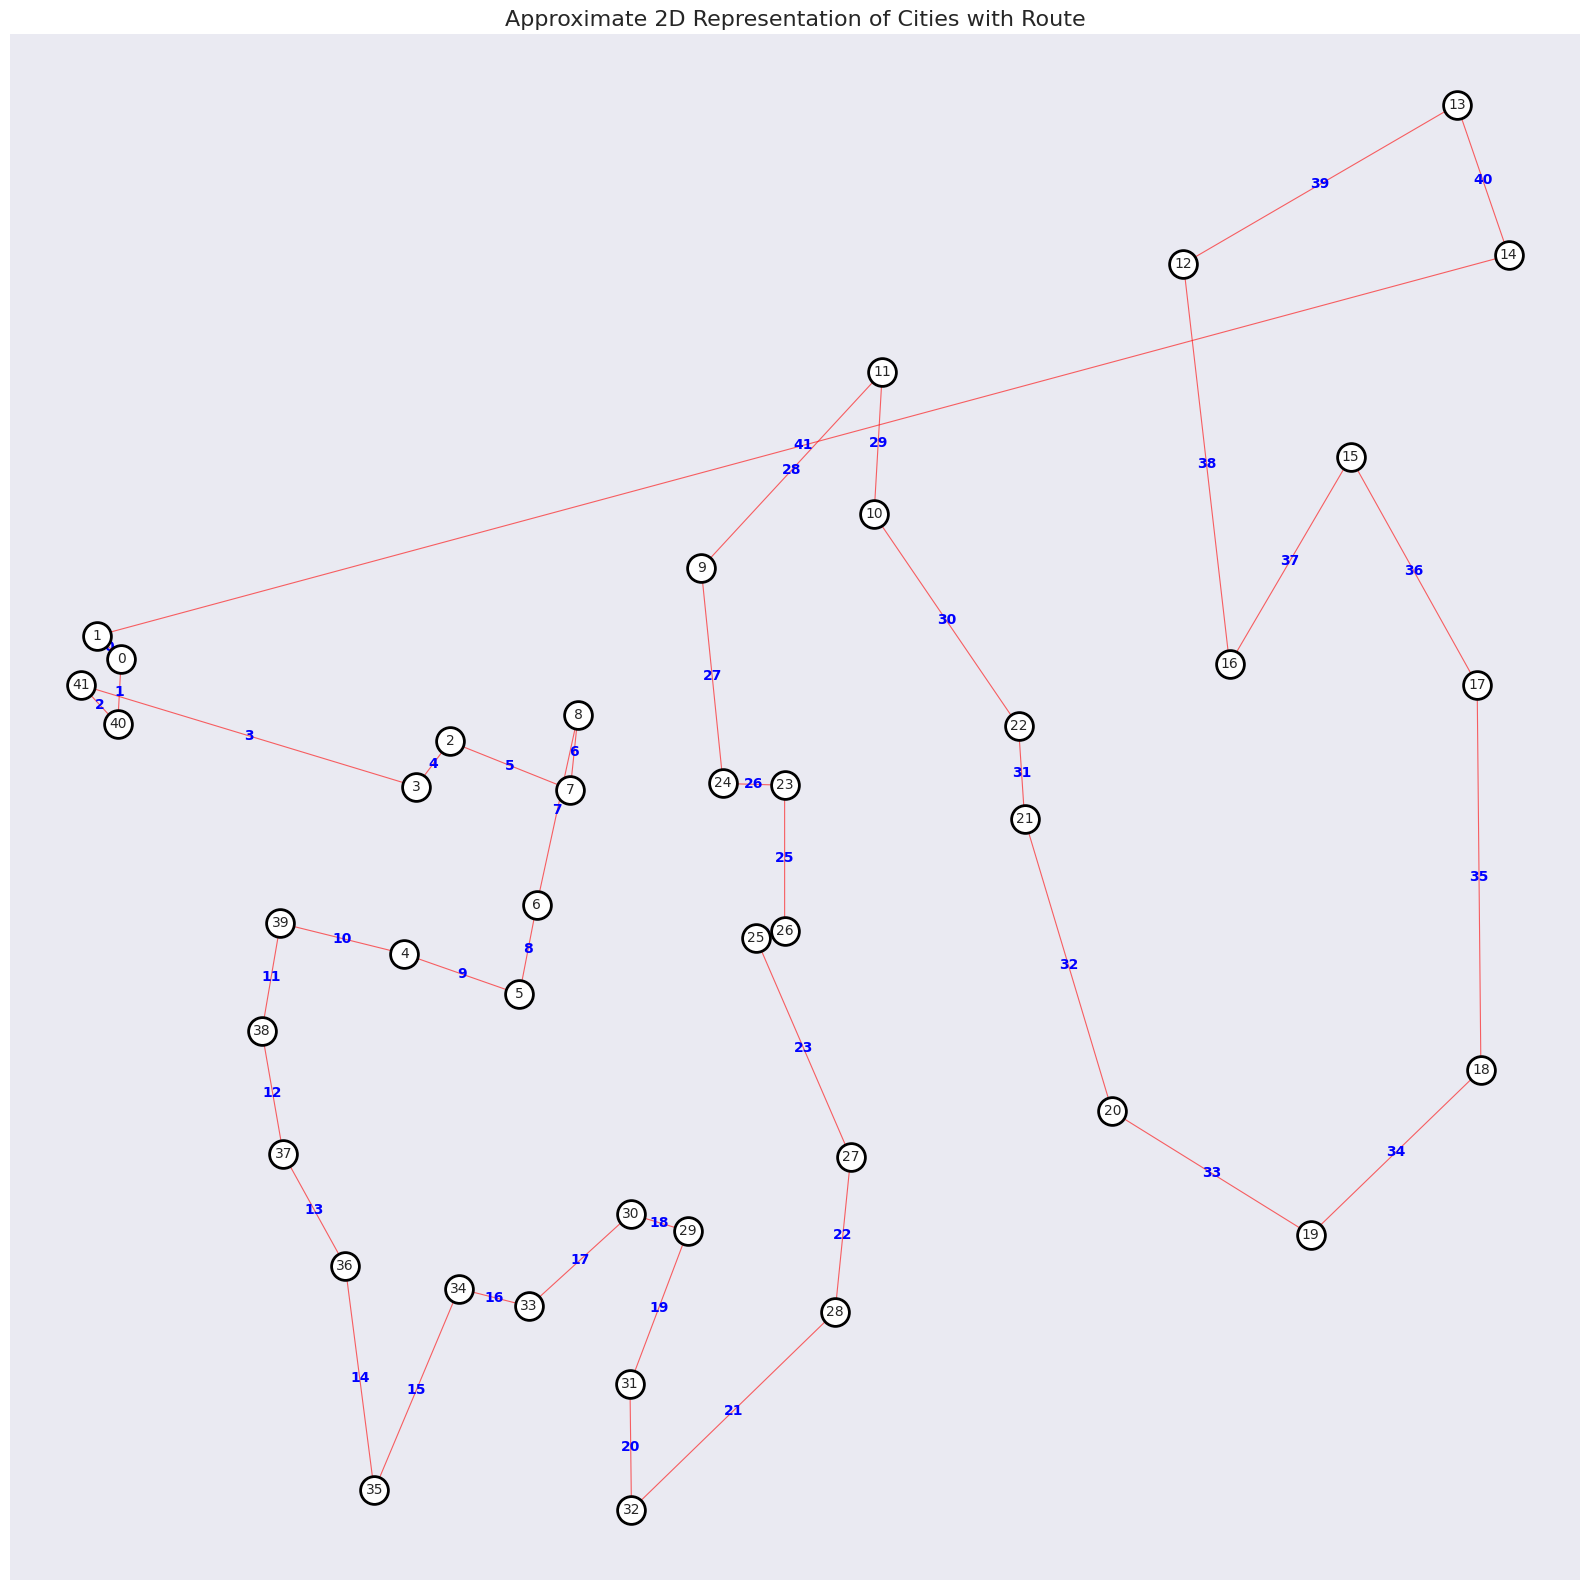

Correlation between original and reconstructed distances: 0.9981


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
from typing import List, Union
import os

def plot_cities_from_distance_matrix(filename: str, solutions: Union[List[int], List[List[int]]] = None, output_dir: str = 'output'):
    # Read the distance matrix from the file
    with open(filename, 'r') as f:
        distances = np.loadtxt(f)

    # Use Multidimensional Scaling (MDS) to get 2D coordinates
    n_cities = distances.shape[0]
    n_components = min(5, max(2, n_cities // 25))  # Adjust components based on city count

    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42, n_init=4, max_iter=300)
    coords = mds.fit_transform(distances)

    # If we used more than 2 components, project back to 2D using PCA
    if n_components > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        coords = pca.fit_transform(coords)

    # Increase the spread of the coordinates
    coords *= 1.5

    # Set a softer color palette
    plt.style.use('seaborn')

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # If no solutions provided, just plot the problem
    if solutions is None:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.scatter(coords[:, 0], coords[:, 1], c='white', s=400, edgecolors='black', linewidth=2, zorder=3)
        for i, (x, y) in enumerate(coords):
            ax.annotate(str(i), (x, y), xytext=(0, 0), textcoords='offset points', 
                        ha='center', va='center', fontsize=10, zorder=4)
        ax.set_title('TSP Problem Visualization', fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'tsp_problem.png'), dpi=300, bbox_inches='tight')
        plt.close()
    else:
        # Ensure solutions is a list of lists
        if isinstance(solutions[0], int):
            solutions = [solutions]

        for idx, solution in enumerate(solutions):
            fig, ax = plt.subplots(figsize=(16, 16))
            
            # Plot the route
            total_cost = 0
            for i in range(len(solution)):
                start = solution[i]
                end = solution[(i + 1) % len(solution)]  # Wrap around to the start
                ax.plot([coords[start, 0], coords[end, 0]], 
                        [coords[start, 1], coords[end, 1]], 
                        'r-', alpha=0.6, linewidth=0.8, zorder=1)
                # Add order labels to the edges in bold
                mid_x = (coords[start, 0] + coords[end, 0]) / 2
                mid_y = (coords[start, 1] + coords[end, 1]) / 2
                ax.annotate(str(i), (mid_x, mid_y), color='blue', fontsize=10, 
                            fontweight='bold', ha='center', va='center', zorder=2)
                
                # Calculate cost
                total_cost += distances[start, end]

            # Plot the cities
            ax.scatter(coords[:, 0], coords[:, 1], c='white', s=400, edgecolors='black', linewidth=2, zorder=3)

            # Add labels for each city
            for i, (x, y) in enumerate(coords):
                ax.annotate(str(i), (x, y), xytext=(0, 0), textcoords='offset points', 
                            ha='center', va='center', fontsize=10, zorder=4)

            ax.set_title(f'Solution {idx + 1}', fontsize=16)
            
            # Add cost label
            ax.text(0.05, 0.95, f'Total Cost: {total_cost:.2f}', transform=ax.transAxes, 
                    fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Remove ticks and grid
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)

            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f'tsp_solution_{idx+1}.png'), dpi=300, bbox_inches='tight')
            plt.close()

    # Verify that the reconstructed distances are similar to the original
    reconstructed_distances = distance_matrix(coords, coords)
    correlation = np.corrcoef(distances.flatten(), reconstructed_distances.flatten())[0, 1]
    print(f"Correlation between original and reconstructed distances: {correlation:.4f}")

# Example usage:
# Sample results from matrix2.txt and ACO algorithm
matrix2_result1 = [41, 40, 0, 1, 37, 38, 39, 4, 3, 2, 7, 8, 6, 5, 33, 34, 36, 35, 32, 31, 30, 29, 28, 27, 25, 26, 23, 24, 9, 11, 10, 22, 21, 20, 19, 18, 17, 15, 16, 12, 13, 14]
matrix2_result2 = [1, 0, 40, 41, 3, 2, 7, 8, 6, 5, 4, 39, 38, 37, 36, 35, 34, 33, 30, 29, 31, 32, 28, 27, 25, 26, 23, 24, 9, 11, 10, 22, 21, 20, 19, 18, 17, 15, 16, 12, 13, 14]

# Plot the TSP problem without solution
plot_cities_from_distance_matrix('data/tsp_graphs/matrix2.txt')

# Plot a single solution
plot_cities_from_distance_matrix('data/tsp_graphs/matrix2.txt', matrix2_result1)

# Plot multiple solutions
plot_cities_from_distance_matrix('data/tsp_graphs/matrix2.txt', [matrix2_result1, matrix2_result2])


/home/hector/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_17787/2811662022.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Correlation between original and reconstructed distances: 0.9981


/home/hector/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_17787/2811662022.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Correlation between original and reconstructed distances: 0.9981


/home/hector/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_17787/2811662022.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Correlation between original and reconstructed distances: 0.9981
